# Import Libraries

In [1]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
np.set_printoptions(suppress=True)
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torch.linalg as linalg

import os
os.chdir("..")


torch.set_printoptions(sci_mode=False)
np.set_printoptions(suppress=True)

## Initial Param

In [2]:
window_size = 24
max_cap = torch.tensor(1)
kw = torch.tensor(60)
kc = torch.tensor(1500)
batch_size = 12 
num_loc = 10
num_train = 250
num_test = 19
num_val = 38

### Load training Data & Preprocess

In [3]:
wl_train = sio.loadmat('./data/Data_by_sliding.mat')['wl_train']
pr_train = sio.loadmat('./data/Data_by_sliding.mat')['pr_train']
wat_train = sio.loadmat('./data/Data_by_sliding.mat')['wat_train']
car_train = sio.loadmat('./data/Data_by_sliding.mat')['car_train']

wl_val = sio.loadmat('./data/Data_by_sliding.mat')['wl_val']
pr_val = sio.loadmat('./data/Data_by_sliding.mat')['pr_val']
wat_val = sio.loadmat('./data/Data_by_sliding.mat')['wat_val']
car_val = sio.loadmat('./data/Data_by_sliding.mat')['car_val']

pr_test = sio.loadmat('./data/Data_by_sliding.mat')['pr_test'][:19,:]
wl_test = sio.loadmat('./data/Data_by_sliding.mat')['wl_test'][:19,:]
wat_test = sio.loadmat('./data/Data_by_sliding.mat')['wat_test'][:19,:]
car_test = sio.loadmat('./data/Data_by_sliding.mat')['car_test'][:19,:]


In [4]:
wl_train = torch.tensor(wl_train).reshape(num_train*window_size,-1)
pr_train = torch.tensor(pr_train).reshape(num_train*window_size,-1)
wat_train = torch.tensor(wat_train).reshape(num_train*window_size,-1)
car_train = torch.tensor(car_train).reshape(num_train*window_size,-1)
print(wl_train.shape,pr_train.shape,wat_train.shape,car_train.shape)

wl_val = torch.tensor(wl_val).reshape(num_val*window_size,-1)
pr_val = torch.tensor(pr_val).reshape(num_val*window_size,-1)
wat_val = torch.tensor(wat_val).reshape(num_val*window_size,-1)
car_val = torch.tensor(car_val).reshape(num_val*window_size,-1)
print(wl_val.shape,pr_val.shape,wat_val.shape,car_val.shape)

wl_test = torch.tensor(wl_test).reshape(num_test*window_size,-1)
pr_test = torch.tensor(pr_test).reshape(num_test*window_size,-1)
wat_test = torch.tensor(wat_test).reshape(num_test*window_size,-1)
car_test = torch.tensor(car_test).reshape(num_test*window_size,-1)
print(wl_test.shape,pr_test.shape,wat_test.shape,car_test.shape)

torch.Size([6000, 1]) torch.Size([6000, 10]) torch.Size([6000, 10]) torch.Size([6000, 10])
torch.Size([912, 1]) torch.Size([912, 10]) torch.Size([912, 10]) torch.Size([912, 10])
torch.Size([456, 1]) torch.Size([456, 10]) torch.Size([456, 10]) torch.Size([456, 10])


In [9]:
def get_Transformed_Data(data,window_size):
    source_array = []
    target_array = []
    for i in range(data.shape[0]-window_size): #124,4 [122-124]+4 = 126
        target = data[i+1:i+window_size+1,:]
        target_array.append(target)
        source_array.append(data[i,:].unsqueeze(0))

    target_array = torch.stack(target_array,axis = 0)
    source_array = torch.stack(source_array,axis = 0)

    return target_array,source_array

In [10]:
target_train_wl,source_train_wl = get_Transformed_Data(wl_train,window_size)
target_train_pr,source_train_pr = get_Transformed_Data(pr_train,window_size)
target_train_wat,source_train_wat = get_Transformed_Data(wat_train,window_size)
target_train_car,source_train_car = get_Transformed_Data(car_train,window_size)

target_val_wl,source_val_wl = get_Transformed_Data(wl_val,window_size)
target_val_pr,source_val_pr = get_Transformed_Data(pr_val,window_size)
target_val_wat,source_val_wat = get_Transformed_Data(wat_val,window_size)
target_val_car,source_val_car = get_Transformed_Data(car_val,window_size)

In [11]:
target_val_wl.shape,source_val_wl.shape

(torch.Size([888, 24, 1]), torch.Size([888, 1, 1]))

In [12]:
target_train_pr = torch.reshape(target_train_pr,(target_train_pr.shape[0]//batch_size,batch_size,num_loc,window_size))
target_train_wat = torch.reshape(target_train_wat,(target_train_wat.shape[0]//batch_size,batch_size,num_loc,window_size))
target_train_car = torch.reshape(target_train_car,(target_train_car.shape[0]//batch_size,batch_size,num_loc, window_size))
target_train_wl = torch.reshape(target_train_wl,(target_train_wl.shape[0]//batch_size,batch_size,1, window_size))

print(target_train_pr.shape,target_train_wat.shape,target_train_car.shape,target_train_wl.shape)

source_train_pr = torch.reshape(source_train_pr,(source_train_pr.shape[0]//batch_size,batch_size, num_loc,1))
source_train_wat = torch.reshape(source_train_wat,(source_train_wat.shape[0]//batch_size,batch_size,num_loc, 1))
source_train_car = torch.reshape(source_train_car,(source_train_car.shape[0]//batch_size,batch_size,num_loc, 1))
source_train_wl = torch.reshape(source_train_wl,(source_train_wl.shape[0]//batch_size,batch_size, 1,1))
print(source_train_pr.shape,source_train_wat.shape,source_train_car.shape,source_train_wl.shape)


torch.Size([498, 12, 10, 24]) torch.Size([498, 12, 10, 24]) torch.Size([498, 12, 10, 24]) torch.Size([498, 12, 1, 24])
torch.Size([498, 12, 10, 1]) torch.Size([498, 12, 10, 1]) torch.Size([498, 12, 10, 1]) torch.Size([498, 12, 1, 1])


In [13]:
target_val_wat.shape

torch.Size([888, 24, 10])

In [14]:
target_val_pr = torch.reshape(target_val_pr,(target_val_pr.shape[0],num_loc,window_size))
target_val_wat = torch.reshape(target_val_wat,(target_val_wat.shape[0],num_loc,window_size))
target_val_car = torch.reshape(target_val_car,(target_val_car.shape[0],num_loc, window_size))
target_val_wl = torch.reshape(target_val_wl,(target_val_wl.shape[0],1, window_size))

print(target_val_pr.shape,target_val_wat.shape,target_val_car.shape,target_val_wl.shape)

source_val_pr = torch.reshape(source_val_pr, (source_val_pr.shape[0],num_loc,1))
source_val_wat = torch.reshape(source_val_wat, (source_val_wat.shape[0],num_loc, 1))
source_val_car = torch.reshape(source_val_wat, (source_val_car.shape[0],num_loc, 1))
source_val_wl = torch.reshape(source_val_wl, (source_val_wl.shape[0], 1,1))
print(source_val_pr.shape,source_val_wat.shape,source_val_car.shape,source_val_wl.shape)

torch.Size([888, 10, 24]) torch.Size([888, 10, 24]) torch.Size([888, 10, 24]) torch.Size([888, 1, 24])
torch.Size([888, 10, 1]) torch.Size([888, 10, 1]) torch.Size([888, 10, 1]) torch.Size([888, 1, 1])


### ML Model 

In [168]:
class TimeSeriesPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(TimeSeriesPredictor, self).__init__()
        self.lstm = nn.GRU(input_size, hidden_size, num_layers,dropout=0.45,batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)
        # self.out_layers = nn.ModuleList([nn.Linear(hidden_size, input_size) for _ in range(output_size)])

        self.window_size = output_size
        self.hidden_dim = hidden_size
        self.num_layers = num_layers

    def forward(self, x,hidden=None,target = None): # the performance is very poor 
        output = []
        if(target == None):
            x_out = x.clone().detach() 
            for i in range(window_size):
                lstm_out, hidden= self.lstm(x_out,hidden)
                x_out = self.linear(lstm_out)
                # print(x_out.shape)
                output.append(x_out)
            # print(len(output))
            output = torch.cat(output,dim = 2)
            # print(output.shape)
        else:
            lstm_out, hidden= self.lstm(x,hidden)
            # print(x.shape)
            x_out = self.linear(lstm_out) 
            output.append(x_out)
            for i in range(1,window_size):
                # print(target[:,:,i].unsqueeze(2).shape)
                lstm_out, hidden= self.lstm(target[:,:,i].unsqueeze(2),hidden)
                x_out = self.linear(lstm_out)
                # print(x_out.shape)
                output.append(x_out)
            # print(len(output))
            output = torch.cat(output,dim = 2)
        return output,hidden

### ML Loss Function and optimizer

In [16]:
torch_seed = 10
torch.random.manual_seed(torch_seed)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))
# learn_rate = 0.0008#0.000088#88 # i cheched 

Using cpu device


In [17]:
num_epochs = 25

In [18]:
criterion = nn.MSELoss()

# Model for workload prediction

In [154]:
workload_model = TimeSeriesPredictor(input_size=1, hidden_size=512, output_size=1, num_layers=3)
wl_optimizer = torch.optim.Adam(workload_model.parameters(), lr=0.000001)

In [155]:
loss_wl_ar = []
for epoch in range(num_epochs):
    hidden = torch.zeros(workload_model.num_layers, source_train_wl[0].size(0), workload_model.hidden_dim, dtype = torch.float32)

    for i in range(len(target_train_wl)):
        wl_optimizer.zero_grad()
        # print(source_train_wl[i].shape,target_train_wl[i].shape )
        outputs,_ = workload_model(source_train_wl[i].float(),hidden,target_train_wl[i].float() )
        loss_wl = criterion(outputs, target_train_wl[i].float())
        # hidden = h_o.detach()
        loss_wl.backward()
        wl_optimizer.step()
    loss_wl_ar.append(loss_wl)
    outputs_val,_ = workload_model(source_val_wl.float())
    loss_wl_val = criterion(outputs_val, target_val_wl.float())
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss_wl.item()}, val-loss:{loss_wl_val.item()},val-shape:{outputs_val.shape}')

Epoch 1/25, Loss: 28.614519119262695, val-loss:37.64884567260742,val-shape:torch.Size([888, 1, 24])
Epoch 2/25, Loss: 10.470897674560547, val-loss:27.59821319580078,val-shape:torch.Size([888, 1, 24])
Epoch 3/25, Loss: 7.43745756149292, val-loss:14.877376556396484,val-shape:torch.Size([888, 1, 24])
Epoch 4/25, Loss: 6.966928958892822, val-loss:12.489830017089844,val-shape:torch.Size([888, 1, 24])
Epoch 5/25, Loss: 6.396089553833008, val-loss:11.07017707824707,val-shape:torch.Size([888, 1, 24])
Epoch 6/25, Loss: 5.8585615158081055, val-loss:9.765816688537598,val-shape:torch.Size([888, 1, 24])
Epoch 7/25, Loss: 5.287935256958008, val-loss:8.533564567565918,val-shape:torch.Size([888, 1, 24])
Epoch 8/25, Loss: 4.814882278442383, val-loss:7.421605110168457,val-shape:torch.Size([888, 1, 24])
Epoch 9/25, Loss: 4.302163124084473, val-loss:6.393039226531982,val-shape:torch.Size([888, 1, 24])
Epoch 10/25, Loss: 3.8752353191375732, val-loss:5.471701145172119,val-shape:torch.Size([888, 1, 24])
Epoc

In [123]:
det_loss_wl_ar = [t.item() for t in loss_wl_ar]

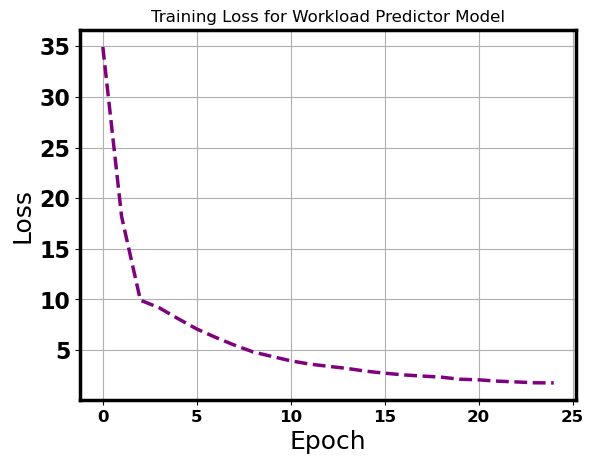

In [124]:
plt.rcParams['axes.linewidth'] = 2.5
plt.plot(det_loss_wl_ar,linestyle = '--',color = 'purple',linewidth = 2.5)
plt.xlabel("Epoch",fontsize = 18)
plt.ylabel("Loss",fontsize = 18)
plt.xticks(fontsize = 12, weight = 'bold')
plt.yticks(fontsize = 16, weight = 'bold')
plt.title('Training Loss for Workload Predictor Model')
plt.grid()
# plt.savefig("./data/plot/cost_rem_wl_tradoff.pdf", bbox_inches='tight')
# plt.legend(bbox_to_anchor=(1.60, 1), loc='upper right',)

plt.show()

# Price Data predictor

In [196]:
price_model = TimeSeriesPredictor(input_size=1, hidden_size=512, output_size=1, num_layers=3)
pr_optimizer = torch.optim.Adam(price_model.parameters(), lr=0.0001)

In [197]:
loss_pr_ar = []
for epoch in range(num_epochs):
    hidden = torch.zeros(price_model.num_layers, source_train_pr[0].size(0), price_model.hidden_dim, dtype = torch.float32)

    for i in range(len(target_train_pr)):
        pr_optimizer.zero_grad()
        outputs,_ = price_model(source_train_pr[i].float(),hidden,target_train_pr[i].float())
        loss_pr = criterion(outputs, target_train_pr[i].float())
        loss_pr.backward()
        pr_optimizer.step()
    loss_pr_ar.append(loss_pr)
    print(f'Epoch {epoch+1}/{200}, Loss: {loss_pr.item()}')

Epoch 1/200, Loss: 52059.27734375
Epoch 2/200, Loss: 45329.2734375
Epoch 3/200, Loss: 39929.2421875
Epoch 4/200, Loss: 35621.61328125
Epoch 5/200, Loss: 32222.14453125
Epoch 6/200, Loss: 29574.9453125
Epoch 7/200, Loss: 27543.5859375
Epoch 8/200, Loss: 26007.341796875
Epoch 9/200, Loss: 22978.74609375
Epoch 10/200, Loss: 19570.94140625
Epoch 11/200, Loss: 16953.119140625
Epoch 12/200, Loss: 14745.8974609375
Epoch 13/200, Loss: 12836.259765625
Epoch 14/200, Loss: 11177.4775390625
Epoch 15/200, Loss: 9714.0478515625
Epoch 16/200, Loss: 8463.72265625
Epoch 17/200, Loss: 7332.27978515625
Epoch 18/200, Loss: 6383.63330078125
Epoch 19/200, Loss: 5524.119140625
Epoch 20/200, Loss: 4801.36962890625
Epoch 21/200, Loss: 4180.39599609375
Epoch 22/200, Loss: 3659.79931640625
Epoch 23/200, Loss: 3255.20556640625
Epoch 24/200, Loss: 2880.599365234375
Epoch 25/200, Loss: 2567.84814453125


In [198]:
det_loss_pr_ar = [t.item() for t in loss_pr_ar]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


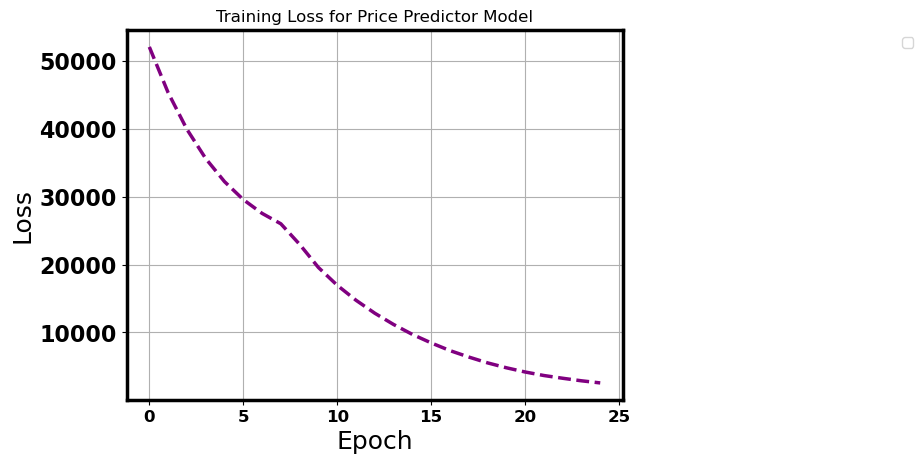

In [199]:
plt.rcParams['axes.linewidth'] = 2.5
plt.plot(det_loss_pr_ar,linestyle = '--',color = 'purple',linewidth = 2.5)
plt.xlabel("Epoch",fontsize = 18)
plt.ylabel("Loss",fontsize = 18)
plt.xticks(fontsize = 12, weight = 'bold')
plt.yticks(fontsize = 16, weight = 'bold')
plt.title('Training Loss for Price Predictor Model')
plt.grid()
# plt.savefig("./data/plot/cost_rem_wl_tradoff.pdf", bbox_inches='tight')
plt.legend(bbox_to_anchor=(1.60, 1), loc='upper right',)

plt.show()

# Water efficiency predictor

In [171]:
water_model = TimeSeriesPredictor(input_size=1, hidden_size=256, output_size=1, num_layers=3)
wat_optimizer = torch.optim.Adam(water_model.parameters(), lr=0.00001)

In [172]:
loss_wat_ar = []
for epoch in range(num_epochs):
    hidden = torch.zeros(water_model.num_layers, source_train_wat[0].size(0), water_model.hidden_dim, dtype = torch.float32)

    for i in range(len(target_train_wat)):
        wat_optimizer.zero_grad()
        outputs,_ = water_model(source_train_wat[i].float(),hidden,target_train_wat[i].float())
        loss_wat = criterion(outputs, target_train_wat[i].float())
        loss_wat.backward()
        wat_optimizer.step()
    loss_wat_ar.append(loss_wat)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss_wat.item()}')

Epoch 1/25, Loss: 0.8108012676239014
Epoch 2/25, Loss: 0.7406632304191589
Epoch 3/25, Loss: 0.6784437894821167
Epoch 4/25, Loss: 0.6206570863723755
Epoch 5/25, Loss: 0.5554673075675964
Epoch 6/25, Loss: 0.47852393984794617
Epoch 7/25, Loss: 0.40728920698165894
Epoch 8/25, Loss: 0.33775120973587036
Epoch 9/25, Loss: 0.2739124000072479
Epoch 10/25, Loss: 0.22658008337020874
Epoch 11/25, Loss: 0.1971554011106491
Epoch 12/25, Loss: 0.18455927073955536
Epoch 13/25, Loss: 0.1674647182226181
Epoch 14/25, Loss: 0.15755827724933624
Epoch 15/25, Loss: 0.1401694118976593
Epoch 16/25, Loss: 0.1314655989408493
Epoch 17/25, Loss: 0.12355618923902512
Epoch 18/25, Loss: 0.1097937822341919
Epoch 19/25, Loss: 0.11211865395307541
Epoch 20/25, Loss: 0.10483862459659576
Epoch 21/25, Loss: 0.09878384321928024
Epoch 22/25, Loss: 0.09462986141443253
Epoch 23/25, Loss: 0.08908578008413315
Epoch 24/25, Loss: 0.08870278298854828
Epoch 25/25, Loss: 0.07898718863725662


In [177]:
det_loss_wat_ar = [t.item() for t in loss_wat_ar]

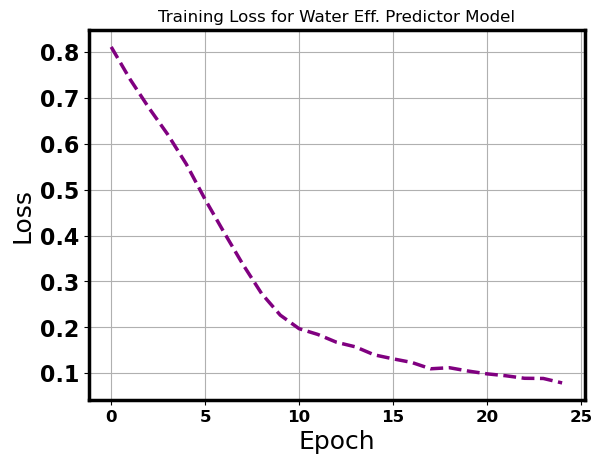

In [178]:
plt.rcParams['axes.linewidth'] = 2.5
plt.plot(det_loss_wat_ar,linestyle = '--',color = 'purple',linewidth = 2.5)
plt.xlabel("Epoch",fontsize = 18)
plt.ylabel("Loss",fontsize = 18)
plt.xticks(fontsize = 12, weight = 'bold')
plt.yticks(fontsize = 16, weight = 'bold')
plt.title('Training Loss for Water Eff. Predictor Model')
plt.grid()
# plt.savefig("./data/plot/cost_rem_wl_tradoff.pdf", bbox_inches='tight')
# plt.legend(bbox_to_anchor=(1.60, 1), loc='upper right',)

plt.show()

# Carbon Efficiency Predictor

In [173]:
carbon_model = TimeSeriesPredictor(input_size=1, hidden_size=256, output_size=1, num_layers=3)
car_optimizer = torch.optim.Adam(carbon_model.parameters(), lr=0.00001)

In [174]:
loss_car_ar = []
for epoch in range(num_epochs):
    hidden = torch.zeros(carbon_model.num_layers, source_train_car[0].size(0), carbon_model.hidden_dim, dtype = torch.float32)

    for i in range(len(target_train_pr)):
        car_optimizer.zero_grad()
        outputs,_ = carbon_model(source_train_car[i].float(),hidden,target_train_car[i].float())
        loss_car = criterion(outputs, target_train_car[i].float())
        loss_car.backward()
        car_optimizer.step()
    loss_car_ar.append(loss_car)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss_car.item()}')

Epoch 1/25, Loss: 0.006722897756844759
Epoch 2/25, Loss: 0.0064902412705123425
Epoch 3/25, Loss: 0.006307286210358143
Epoch 4/25, Loss: 0.006341361906379461
Epoch 5/25, Loss: 0.006237099412828684
Epoch 6/25, Loss: 0.006204709876328707
Epoch 7/25, Loss: 0.005893787369132042
Epoch 8/25, Loss: 0.005802192725241184
Epoch 9/25, Loss: 0.00564214400947094
Epoch 10/25, Loss: 0.005333284847438335
Epoch 11/25, Loss: 0.005161739885807037
Epoch 12/25, Loss: 0.004732539877295494
Epoch 13/25, Loss: 0.004334342200309038
Epoch 14/25, Loss: 0.003716734005138278
Epoch 15/25, Loss: 0.0031189469154924154
Epoch 16/25, Loss: 0.0024084332399070263
Epoch 17/25, Loss: 0.0017941610421985388
Epoch 18/25, Loss: 0.0013904727529734373
Epoch 19/25, Loss: 0.001293001463636756
Epoch 20/25, Loss: 0.0010285894386470318
Epoch 21/25, Loss: 0.0008495314978063107
Epoch 22/25, Loss: 0.0007464736117981374
Epoch 23/25, Loss: 0.0006523785414174199
Epoch 24/25, Loss: 0.0006075517740100622
Epoch 25/25, Loss: 0.0005768254632130265

In [179]:
det_loss_car_ar = [t.item() for t in loss_car_ar]

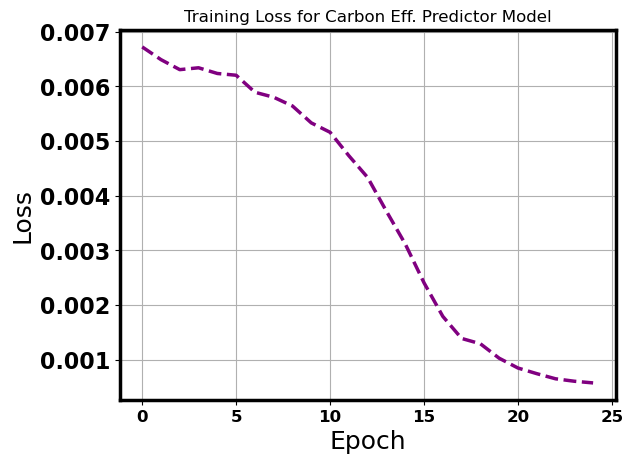

In [180]:
plt.rcParams['axes.linewidth'] = 2.5
plt.plot(det_loss_car_ar,linestyle = '--',color = 'purple',linewidth = 2.5)
plt.xlabel("Epoch",fontsize = 18)
plt.ylabel("Loss",fontsize = 18)
plt.xticks(fontsize = 12, weight = 'bold')
plt.yticks(fontsize = 16, weight = 'bold')
plt.title('Training Loss for Carbon Eff. Predictor Model')
plt.grid()
# plt.savefig("./data/plot/cost_rem_wl_tradoff.pdf", bbox_inches='tight')
# plt.legend(bbox_to_anchor=(1.60, 1), loc='upper right',)

plt.show()

In [52]:
from utils.solve import mpc_solver,offline_solver_cc, evaluate_single, evaluate_total

### MPC Parameters and test data

In [55]:
l_1 = 60       # mu_water for the water consumption weight
l_2 = 1500     # mu_carbon for carbon emission weight
# num_ins = 24

In [56]:
wl_test.shape,pr_test.shape,car_test.shape,wat_test.shape

(torch.Size([456, 1, 1]),
 torch.Size([456, 10, 1]),
 torch.Size([456, 10, 1]),
 torch.Size([456, 10, 1]))

In [181]:
workload_trace = wl_test.numpy().reshape(1,-1)
price_all_loc =  pr_test.numpy().reshape(10,-1)
water_all_loc =  wat_test.numpy().reshape(10,-1)
carbon_all_loc =  car_test.numpy().reshape(10,-1)
workload_trace.shape,price_all_loc.shape,water_all_loc.shape,carbon_all_loc.shape

((1, 456), (10, 456), (10, 456), (10, 456))

In [182]:
wl_test = torch.reshape(wl_test,(wl_test.shape[0],1,1))
pr_test = torch.reshape(pr_test,(pr_test.shape[0],10,1))
car_test = torch.reshape(car_test,(car_test.shape[0],10,1))
wat_test = torch.reshape(wat_test,(wat_test.shape[0],10,1))
wl_test.shape,pr_test.shape,car_test.shape,wat_test.shape

(torch.Size([456, 1, 1]),
 torch.Size([456, 10, 1]),
 torch.Size([456, 10, 1]),
 torch.Size([456, 10, 1]))

# Predicted context (Workload, Price, Wate and carbon)

In [183]:
predicted_workload_test,_ = workload_model(wl_test.float())

In [186]:
predicted_carbon_test,_ = carbon_model(car_test.float())
predicted_water_test,_ = water_model(wat_test.float())

In [200]:
predicted_price_test,_ = price_model(pr_test.float())

In [187]:
predicted_carbon_test.shape,predicted_water_test.shape,predicted_price_test.shape,predicted_workload_test.shape

(torch.Size([456, 10, 24]),
 torch.Size([456, 10, 24]),
 torch.Size([456, 10, 24]),
 torch.Size([456, 1, 24]))

In [188]:
predicted_workload_test_np = predicted_workload_test.detach().numpy()

In [189]:
predicted_carbon_test_np = predicted_carbon_test.detach().numpy()
predicted_water_test_np = predicted_water_test.detach().numpy()

In [201]:
predicted_price_test_np = predicted_price_test.detach().numpy()

In [190]:
predicted_carbon_test_np.shape,predicted_workload_test_np.shape

((456, 10, 24), (456, 1, 24))

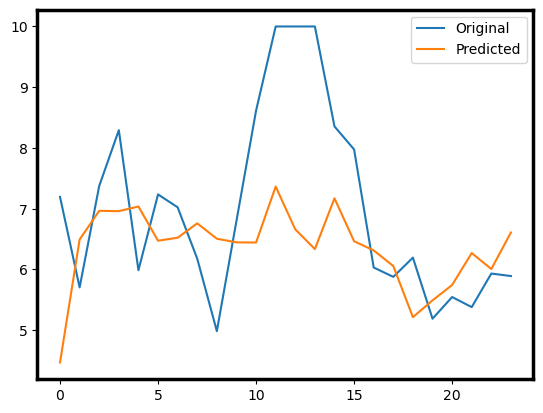

In [191]:
plt.plot(workload_trace[:,0:24].reshape(-1,1),label = 'Original')
plt.plot(predicted_workload_test_np[0].reshape(-1,1),label = 'Predicted')
plt.legend()

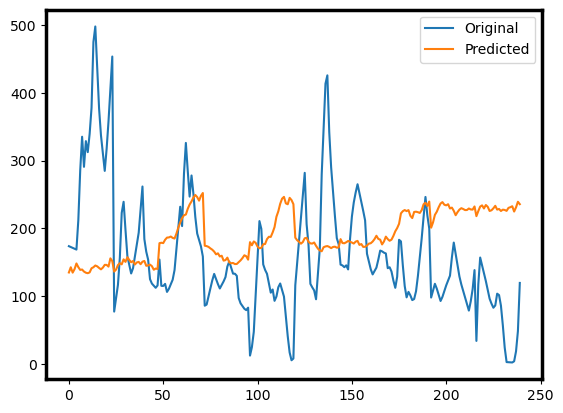

In [202]:
plt.plot(price_all_loc[:,0:24].reshape(-1,1),label = 'Original')
plt.plot(predicted_price_test_np[0].reshape(-1,1),label = 'Predicted')
plt.legend()

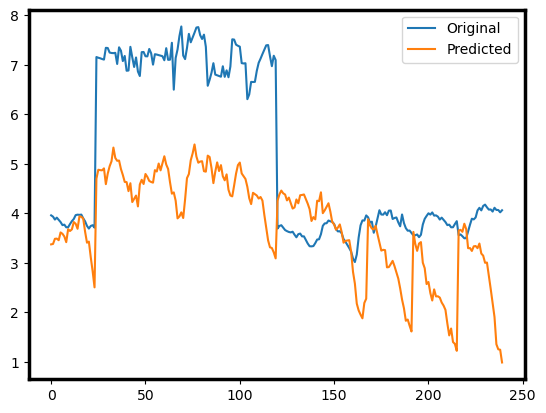

In [193]:
plt.plot(water_all_loc[:,0:24].reshape(-1,1),label = 'Original')
plt.plot(predicted_water_test_np[0].reshape(-1,1),label = 'Predicted')
plt.legend()

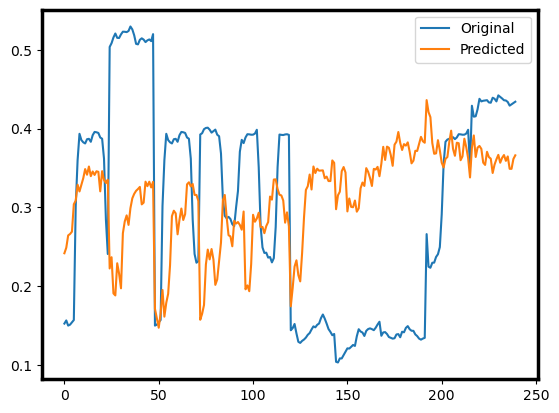

In [194]:
plt.plot(carbon_all_loc[:,0:24].reshape(-1,1),label = 'Original')
plt.plot(predicted_carbon_test_np[0].reshape(-1,1),label = 'Predicted')
plt.legend()

In [67]:
predicted_price_test_np[0].shape,price_all_loc[:,:24].shape

((10, 24), (10, 24))

# Tracking the remaining workload in a time window in MPC

In [68]:
def distribute_rem_wl(data,remwl):
    i  = 0
    while remwl!=0:
        if(i>=data.shape[1]):
            break
        data[0,i]+= remwl
        if(data[0,i]>10):
            remwl = data[0,i]  - 10
            data[0,i]  = 10
            i+=1
            # print(remwl)
        else:
            remwl = 0
    return data,remwl    

# MPC Solver Equitable

In [69]:
optimal_action_off = []
rem_wl = 0
historical_e_cost = 0
historical_w_cost = np.zeros(10)
historical_c_cost = np.zeros(10)
for i in range(num_test*window_size):
    pr_i = predicted_price_test_np[i]
    wat_i = predicted_water_test_np[i]
    car_i = predicted_carbon_test_np[i]
    wl_i = predicted_workload_test_np[i]
    # print(wl_i)
    combined_pr_i = np.concatenate([price_all_loc[:,[i]],pr_i],axis = 1)
    combined_wat_i = np.concatenate([water_all_loc[:,[i]],wat_i],axis = 1)
    combined_car_i = np.concatenate([carbon_all_loc[:,[i]],car_i],axis = 1)
    combined_wl_i = np.concatenate([workload_trace[:,[i]],wl_i],axis = 1)
    combined_wl_i,rem_t =  distribute_rem_wl(combined_wl_i ,rem_wl)
    # combined_wl_i[0][0]+= rem_wl
    # combined_wl_i[0][0] = min(10,wl_i[0][0] )
    optimal_cost,y = mpc_solver(combined_pr_i, combined_wat_i,combined_car_i,combined_wl_i,combined_pr_i.shape[1],
                                historical_e_cost,historical_w_cost,historical_c_cost,
                            verbose=False,l_0=1, l_1 = l_1, l_2 = l_2,f_type = "MAX")
   
    historical_e_cost += np.sum(np.multiply(y[:,0],price_all_loc[:,i]))
    historical_w_cost += np.multiply(y[:,0],water_all_loc[:,i])
    historical_c_cost += np.multiply(y[:,0],carbon_all_loc[:,i])
    optimal_action_off.append(y[:,0])
    rem_wl += np.sum(workload_trace[:,i]) - np.sum(y[:,0]) + rem_t
    # print(workload_trace[:,[i]],np.sum(y[:,0]),rem_wl,rem_t)

    # break
optimal_action_off = np.stack(optimal_action_off,axis = 1)


# MPC Energy Only

In [70]:
mpc_action_pr = []
rem_wl = 0
historical_e_cost = 0
historical_w_cost = np.zeros(10)
historical_c_cost = np.zeros(10)
for i in range(num_test*window_size):
    pr_i = predicted_price_test_np[i]
    wat_i = predicted_water_test_np[i]
    car_i = predicted_carbon_test_np[i]
    wl_i = predicted_workload_test_np[i]

    combined_pr_i = np.concatenate([price_all_loc[:,[i]],pr_i],axis = 1)
    combined_wat_i = np.concatenate([water_all_loc[:,[i]],wat_i],axis = 1)
    combined_car_i = np.concatenate([carbon_all_loc[:,[i]],car_i],axis = 1)
    combined_wl_i = np.concatenate([workload_trace[:,[i]],wl_i],axis = 1)
    combined_wl_i,rem_t =  distribute_rem_wl(combined_wl_i ,rem_wl)

    # combined_wl_i[0][0]+= rem_wl
    # combined_wl_i[0][0] = min(10,wl_i[0][0] )
    optimal_cost,y = mpc_solver(combined_pr_i, combined_wat_i,combined_car_i,combined_wl_i,combined_pr_i.shape[1],
                                historical_e_cost,historical_w_cost,historical_c_cost,
                            verbose=False,l_0=1, l_1 = 0, l_2 = 0,f_type = "AVG")
   
    historical_e_cost += np.sum(np.multiply(y[:,0],price_all_loc[:,i]))
    historical_w_cost += np.multiply(y[:,0],water_all_loc[:,i])
    historical_c_cost += np.multiply(y[:,0],carbon_all_loc[:,i])
    mpc_action_pr.append(y[:,0])
    rem_wl += np.sum(workload_trace[:,i]) - np.sum(y[:,0]) + rem_t
    # print(workload_trace[:,[i]],np.sum(y[:,0]),rem_wl,rem_t,np.sum(combined_wl_i)-np.sum(y))


mpc_action_pr = np.stack(mpc_action_pr,axis = 1)

# Offline Equitable 

In [71]:
optimal_cost,action_off  = offline_solver_cc(price_all_loc, water_all_loc,carbon_all_loc,
                                        workload_trace,price_all_loc.shape[1], verbose=False, l_1 = l_1, 
                                        l_2 = l_2,f_type = "MAX")

# Offline Energy Only 


In [72]:
optimal_cost,action_off_pr_only  = offline_solver_cc(price_all_loc, water_all_loc,carbon_all_loc,
                                        workload_trace,price_all_loc.shape[1], verbose=False, l_1 = 0, 
                                        l_2 = 0,f_type = "AVG")

# Cost/Footprints Computation

In [73]:
price_res   = evaluate_single(action_off, price_all_loc)
water_res   = evaluate_single(action_off, water_all_loc)
carbon_res  = evaluate_single(action_off, carbon_all_loc)
evaluate_total(action_off, price_all_loc,carbon_all_loc,water_all_loc,
                l_1, l_2, verbose = True, l_0 = 1)
# Mean and max of electricity price
# print(price_res)

print("Mean and Max Power")

print(np.mean(price_res))
print(np.max(price_res))

# Mean and max of water consumption
print("Mean and Max Water")

print(np.mean(water_res))
print(np.max(water_res))

# Mean and max of carbon emission
print("Mean and Max Carbon")

print(np.mean(carbon_res))
print(np.max(carbon_res))

print("*"*50)

Electric price  :  325218.255
Total water     :  82259.190
Total carbon    :  122615.874
-----
Overall Cost    :  530093.319
Mean and Max Power
32521.825546056712
45120.39553468698
Mean and Max Water
1253.6571640892091
1370.986493052209
Mean and Max Carbon
75.9745209949721
81.74391630220892
**************************************************


In [74]:
price_res   = evaluate_single(action_off_pr_only, price_all_loc)
water_res   = evaluate_single(action_off_pr_only, water_all_loc)
carbon_res  = evaluate_single(action_off_pr_only, carbon_all_loc)
evaluate_total(action_off_pr_only, price_all_loc,carbon_all_loc,water_all_loc,
                l_1, l_2, verbose = True, l_0 = 1)
# Mean and max of electricity price
# print(price_res)

print("Mean and Max Power")

print(np.mean(price_res))
print(np.max(price_res))

# Mean and max of water consumption
print("Mean and Max Water")

print(np.mean(water_res))
print(np.max(water_res))

# Mean and max of carbon emission
print("Mean and Max Carbon")

print(np.mean(carbon_res))
print(np.max(carbon_res))

print("*"*50)

Electric price  :  311763.956
Total water     :  99880.383
Total carbon    :  168193.467
-----
Overall Cost    :  579837.806
Mean and Max Power
31176.395550933026
37846.324082392464
Mean and Max Water
1277.6542782489678
1664.6730517142933
Mean and Max Carbon
81.2786628710536
112.12897797341932
**************************************************


In [75]:
np.sum(workload_trace) - np.sum(optimal_action_off)

-7.164544513216242e-09

In [76]:
price_res   = evaluate_single(optimal_action_off, price_all_loc)
water_res   = evaluate_single(optimal_action_off, water_all_loc)
carbon_res  = evaluate_single(optimal_action_off, carbon_all_loc)
print(price_res.shape)
evaluate_total(optimal_action_off, price_all_loc,carbon_all_loc,water_all_loc,
                l_1, l_2, verbose = True, l_0 = 1)
# Mean and max of electricity price
# print(price_res)

print("Mean and Max Power")

print(np.mean(price_res))
print(np.max(price_res))

# Mean and max of water consumption
print("Mean and Max Water")

print(np.mean(water_res))
print(np.max(water_res))

# Mean and max of carbon emission
print("Mean and Max Carbon")

print(np.mean(carbon_res))
print(np.max(carbon_res))

print("*"*50)

(10,)
Electric price  :  362235.189
Total water     :  88476.820
Total carbon    :  129926.720
-----
Overall Cost    :  580638.729
Mean and Max Power
36223.51888309112
47858.064148580386
Mean and Max Water
1253.5520357760583
1474.613674004895
Mean and Max Carbon
73.91012199960949
86.61781301315233
**************************************************


In [77]:
price_res   = evaluate_single(mpc_action_pr, price_all_loc)
water_res   = evaluate_single(mpc_action_pr, water_all_loc)
carbon_res  = evaluate_single(mpc_action_pr, carbon_all_loc)
print(price_res.shape)
evaluate_total(mpc_action_pr, price_all_loc,carbon_all_loc,water_all_loc,
                l_1, l_2, verbose = True, l_0 = 1)
# Mean and max of electricity price
# print(price_res)

print("Mean and Max Power")

print(np.mean(price_res))
print(np.max(price_res))

# Mean and max of water consumption
print("Mean and Max Water")

print(np.mean(water_res))
print(np.max(water_res))

# Mean and max of carbon emission
print("Mean and Max Carbon")

print(np.mean(carbon_res))
print(np.max(carbon_res))

print("*"*50)

(10,)
Electric price  :  329756.670
Total water     :  99757.039
Total carbon    :  171026.595
-----
Overall Cost    :  600540.304
Mean and Max Power
32975.66698323656
40907.89549539358
Mean and Max Water
1283.9177693238628
1662.6173209817807
Mean and Max Carbon
81.76033185080423
114.01772977969333
**************************************************


In [78]:
np.sum(workload_trace) - np.sum(mpc_action_pr)

-4.092726157978177e-12

# Visualization

In [79]:
methods = ['Equitable','Energy']

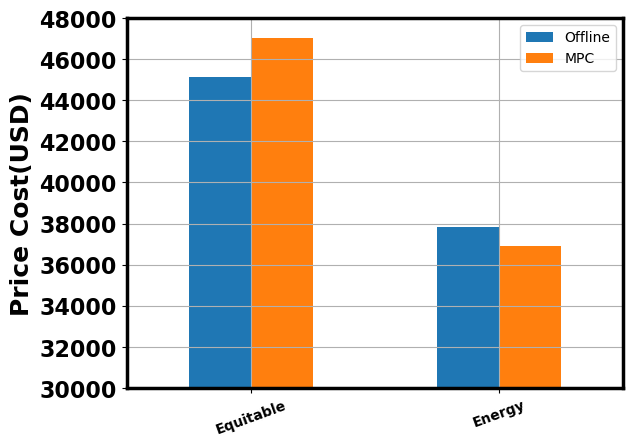

In [80]:
plotdata = pd.DataFrame({
    "Offline":[45120.39553468698,37846.324082392464],
    "MPC":[47039.826954249475,36899.44691909102],
    }, 
    index=methods
)
plotdata.plot(kind="bar")
# plt.title("Mince Pie Consumption Study")
# plt.xlabel("Family Member")
plt.ylim(30000,48000)
plt.ylabel("Price Cost(USD)",fontsize=18,weight = 'bold')
plt.xticks(weight = 'bold',rotation=20)
plt.yticks(fontsize=16,weight = 'bold')
plt.grid()
# plt.savefig("./data/plot/carbon.pdf", bbox_inches='tight')
plt.show()

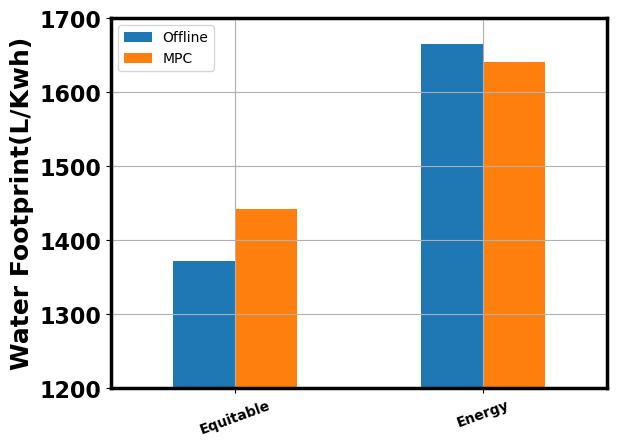

In [81]:
plotdata = pd.DataFrame({
    "Offline":[1370.986493052209,1664.6730517142933],
    "MPC":[1442.2411057318188,1640.4411915341411],
    # "MPC With Error":pr_mpc_err,
    }, 
    index=methods
)
plotdata.plot(kind="bar")
# plt.title("Mince Pie Consumption Study")
# plt.xlabel("Family Member")
plt.ylim(1200,1700)
plt.ylabel("Water Footprint(L/Kwh)",fontsize=18,weight = 'bold')
plt.xticks(weight = 'bold',rotation=20)
plt.yticks(fontsize=16,weight = 'bold')
plt.grid()
# plt.savefig("./data/plot/carbon.pdf", bbox_inches='tight')
plt.show()

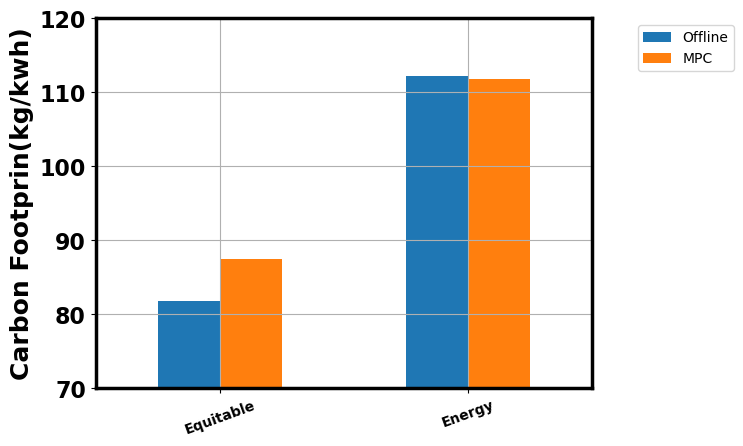

In [82]:
plotdata = pd.DataFrame({
    "Offline":[81.74391630220892,112.12897797341932],
    "MPC":[87.37915060419799,111.7361164817859],
    # "MPC With Error":pr_mpc_err,
    }, 
    index=methods
)
plotdata.plot(kind="bar")
# plt.title("Mince Pie Consumption Study")
# plt.xlabel("Family Member")
plt.ylim(70,120)
plt.ylabel("Carbon Footprin(kg/kwh)",fontsize=18,weight = 'bold')
plt.xticks(weight = 'bold',rotation=20)
plt.yticks(fontsize=16,weight = 'bold')
plt.grid()

plt.legend(bbox_to_anchor=(1.30, 1), loc='upper right',)

# plt.savefig("./data/plot/carbon.pdf", bbox_inches='tight')
plt.show()